In [0]:
import numpy as np
import networkx as nx
import pandas as pd
import random
import functools
from similarities import *
from itertools import combinations 
import math

In [0]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB

In [0]:
path = 'edges.csv'
graph = nx.Graph()
edges = pd.read_csv(path, sep=',', header=None)
graph.add_edges_from(edges.values)
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 10312\nNumber of edges: 333983\nAverage degree:  64.7756'

In [0]:
non_edges = list(nx.non_edges(graph))
edges = list(nx.edges(graph))
# print((non_edges))
m = len(edges)

In [0]:
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

In [0]:
edge_folds = partition(edges,5) 

In [0]:
marked_non_edges = random.sample(non_edges, m)

In [0]:
non_edge_folds = partition(marked_non_edges,5)

In [0]:
len(marked_non_edges),len(non_edge_folds),len(non_edge_folds[0])

(333983, 5, 66797)

In [0]:
for x in edge_folds:  
  print(len(x))

66797
66797
66797
66796
66796


In [0]:
for x in non_edge_folds:  
  print(len(x))

66797
66797
66797
66796
66796


In [0]:
all_nodes = list(graph.nodes)

In [0]:
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
df_trains = []
df_tests = []

In [0]:
def prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix):
  train_edges_len = len(train_edges)
  is_edge = [ 1 ] * train_edges_len + [ 0 ] * train_edges_len
  df_dict = {}
  df_dict['is_edge'] = is_edge
  nodes = list(g_train.nodes)
  
  cn_scores = [ CN_score(g_train,u,v) for (u,v) in train_edges ] + [ CN_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['CN_score'] = cn_scores
  print("Added CN scores....")

  aa_scores = [ AA_score(g_train,u,v) for (u,v) in train_edges ] + [ AA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['AA_score'] = aa_scores
  print("Added AA scores....")

  pa_scores = [ PA_score(g_train,u,v) for (u,v) in train_edges ] + [ PA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['PA_score'] = pa_scores
  print("Added PA scores....")

  ra_scores = [ RA_score(g_train,u,v) for (u,v) in train_edges ] + [ RA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['RA_score'] = ra_scores
  print("Added RA scores....")

  jc_scores = [ JC_score(g_train,u,v) for (u,v) in train_edges ] + [ JC_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['JC_score'] = jc_scores
  print("Added JC scores....")
  
#   @functools.lru_cache(maxsize=None)
#   def RP_calc(u):
#       return rooted_pagerank_score(g_train,u)

  def RP_compute(u,v):
      u = nodes.index(u)
      v = nodes.index(v)
      return rp_matrix[u,v] + rp_matrix[v,u]
    
  rp_scores = [ RP_compute(u, v) for (u,v) in train_edges ] + [ RP_compute(u,v) for (u,v) in train_edges_false ]
  df_dict['RP_score'] = rp_scores
  print("Added RP scores....")
  
#   katz_matrix = katz_score(g_train)
  
  katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges_false ]
  df_dict['KATZ_score'] = katz_scores
  print("Added KATZ scores....")
  
#   friends_measures = [ friends_measure(g_train,u,v) for (u,v) in train_edges ] + [ friends_measure(g_train,u,v) for (u,v) in train_edges_false ]
#   df_dict['friends_measure'] = friends_measures
#   print("Added friends measure scores....")
  
  df = pd.DataFrame(df_dict)
#   print(df)
#   df_list.append(df)
  df_shuffled = df.sample(frac=1).reset_index(drop=True)
  y = df_shuffled['is_edge']
  X = df_shuffled.drop(['is_edge'],axis =1)
  scaler = MinMaxScaler(feature_range=(0, 1))
  # X = scaler.fit_transform(X)
  X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
  
  return X, y
  

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train,beta = 0.001)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  clf = SVC(probability=True) 
  clf.fit(X_train, y_train)
  
  y_pred = clf.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5005688878243035
[[66797     0]
 [66721    76]]
precision score: 1.0
recall score: 0.0011377756486069734
AUC score: 0.9548542579495718
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5011602317469347
[[66797     0]
 [66642   155]]
precision score: 1.0
recall score: 0.0023204634938694853
AUC score: 0.9564527907890371
completed iteration 1
preparing for iteration 2
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5013773073641031
[[66797     0]
 [66613   184]]
precision score: 1.0
recall score: 0.0027546147282063566
AUC score: 0.9574252947939432
completed iteration 2
preparing for iteration 3
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267187
Average degree:  51.8206
Preparing train dataset for this iteration
267187 267187
66796 66796
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5013997844182286
[[66796     0]
 [66609   187]]
precision score: 1.0
recall score: 0.002799568836457273
AUC score: 0.9564631338958334
completed iteration 3
preparing for iteration 4
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267187
Average degree:  51.8206
Preparing train dataset for this iteration
267187 267187
66796 66796
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5014596682436074
[[66796     0]
 [66601   195]]
precision score: 1.0
recall score: 0.0029193364872148035
AUC score: 0.9538758687345903
completed iteration 4


In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 1.0
avg. recall: 0.0023863518388709784
avg. auc: 0.9558142692325952


NAIVE BAYES

In [0]:
print('NAIVE BAYES')
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train,beta = 0.001)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  clf = GaussianNB() 
  clf.fit(X_train, y_train)
  
  y_pred = clf.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

NAIVE BAYES
preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared
Accuracy score: 0.8265191550518736
[[45482 21315]
 [ 1861 64936]]
precision score: 0.7528724304645743
recall score: 0.9721394673413477
AUC score: 0.8412538819033899
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added 

In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.8138322158973976
avg. recall: 0.9441647156789135
avg. auc: 0.8834893927459173


PCA MODELLING

In [0]:
def prepare_X_y_PCA(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix):
  train_edges_len = len(train_edges)
  is_edge = [ 1 ] * train_edges_len + [ 0 ] * train_edges_len
  df_dict = {}
  df_dict['is_edge'] = is_edge
  nodes = list(g_train.nodes)
  
  cn_scores = [ CN_score(g_train,u,v) for (u,v) in train_edges ] + [ CN_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['CN_score'] = cn_scores
  print("Added CN scores....")

  aa_scores = [ AA_score(g_train,u,v) for (u,v) in train_edges ] + [ AA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['AA_score'] = aa_scores
  print("Added AA scores....")

  pa_scores = [ PA_score(g_train,u,v) for (u,v) in train_edges ] + [ PA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['PA_score'] = pa_scores
  print("Added PA scores....")

  ra_scores = [ RA_score(g_train,u,v) for (u,v) in train_edges ] + [ RA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['RA_score'] = ra_scores
  print("Added RA scores....")

  jc_scores = [ JC_score(g_train,u,v) for (u,v) in train_edges ] + [ JC_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['JC_score'] = jc_scores
  print("Added JC scores....")
  
#   @functools.lru_cache(maxsize=None)
#   def RP_calc(u):
#       return rooted_pagerank_score(g_train,u)

  def RP_compute(u,v):
      u = nodes.index(u)
      v = nodes.index(v)
      return rp_matrix[u,v] + rp_matrix[v,u]
    
  rp_scores = [ RP_compute(u, v) for (u,v) in train_edges ] + [ RP_compute(u,v) for (u,v) in train_edges_false ]
  df_dict['RP_score'] = rp_scores
  print("Added RP scores....")
  
#   katz_matrix = katz_score(g_train)
  
  katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges_false ]
  df_dict['KATZ_score'] = katz_scores
  print("Added KATZ scores....")
  
#   friends_measures = [ friends_measure(g_train,u,v) for (u,v) in train_edges ] + [ friends_measure(g_train,u,v) for (u,v) in train_edges_false ]
#   df_dict['friends_measure'] = friends_measures
#   print("Added friends measure scores....")
  
  df = pd.DataFrame(df_dict)
#   print(df)
#   df_list.append(df)
  df_shuffled = df.sample(frac=1).reset_index(drop=True)
  y = df_shuffled['is_edge']
  X = df_shuffled.drop(['is_edge'],axis =1)
#   scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = StandardScaler()
  # X = scaler.fit_transform(X)
  X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
  
  return X, y
  

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train,beta = 0.001)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y_PCA(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y_PCA(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  print('PCA modelling....')
  
  pca = PCA(.95)
  pca.fit(X_train)
  print("No. of pca components: {}".format(pca.n_components_)) 
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  print(pca.explained_variance_)
  
  
  clf = SVC(probability=True, kernel='linear') 
  clf.fit(X_train_pca, y_train)
  
  y_pred = clf.predict(X_test_pca)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test_pca)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared
PCA modelling....
No. of pca components: 4
[4.25153855 1.30722759 0.88200709 0.41244067]
Accuracy score: 0.8400452116112999
[[64788  2009]
 [19360 47437]]
precision score: 0.9593698175787728
recall score: 0.7101666242495921
AUC score: 0.9576056732124164
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
6

In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.9540542944425956
avg. recall: 0.736136413494862
avg. auc: 0.9574101906422474


SVD MODELLING

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train,beta = 0.001)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y_PCA(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y_PCA(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  print('SVD modelling....')
  
  svd = TruncatedSVD(n_components=4)
  svd.fit(X_train)
#   print("No. of pca components: {}".format(svd.n_components_)) 
  X_train_svd = svd.transform(X_train)
  X_test_svd = svd.transform(X_test)
  print(svd.explained_variance_)
  
  
  clf = SVC(probability=True ,kernel='linear') 
  clf.fit(X_train_svd, y_train)
  
  y_pred = clf.predict(X_test_svd)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test_svd)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Test set prepared
SVD modelling....
[4.25251517 1.30806765 0.8840835  0.41204676]
Accuracy score: 0.8632049343533392
[[63886  2911]
 [15364 51433]]
precision score: 0.9464338289415575
recall score: 0.7699896701947693
AUC score: 0.9568907299232083
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 10312
Number of edges: 267186
Average degree:  51.8204
Preparing train dataset for this iteration
267186 267186
66797 66797
Added CN score

In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.945868081809609
avg. recall: 0.7760874186874596
avg. auc: 0.957151013616456


In [0]:
# df_dict['node1'] = [ x[0] for x in edges ] + [ x[0] for x in marked_non_edges]
# df_dict['node2'] = [ x[1] for x in edges ] + [ x[1] for x in marked_non_edges]

In [0]:
# from google.colab import files
# df.to_csv('prepared_datset2.csv', index= False)
# files.download('prepared_datset2.csv')

In [0]:
# X['in_same_community'] = X['in_same_community'].map({True: 1, False: 0})

In [0]:
X

In [0]:
X

In [0]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

In [0]:
#apply SelectKBest class to extract top 10 best features
# bestfeatures = SelectKBest(score_func=chi2, k='all')
# fit = bestfeatures.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))  #print 10 best features

        Specs          Score
5  KATZ_score  149957.825372
0    CN_score    6009.300830
4    JC_score    4690.868625
1    AA_score    4623.322931
2    PA_score    2803.592634
3    RA_score    1766.826813


In [0]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(9).plot(kind='barh')
# plt.show()

In [0]:
import seaborn as sns

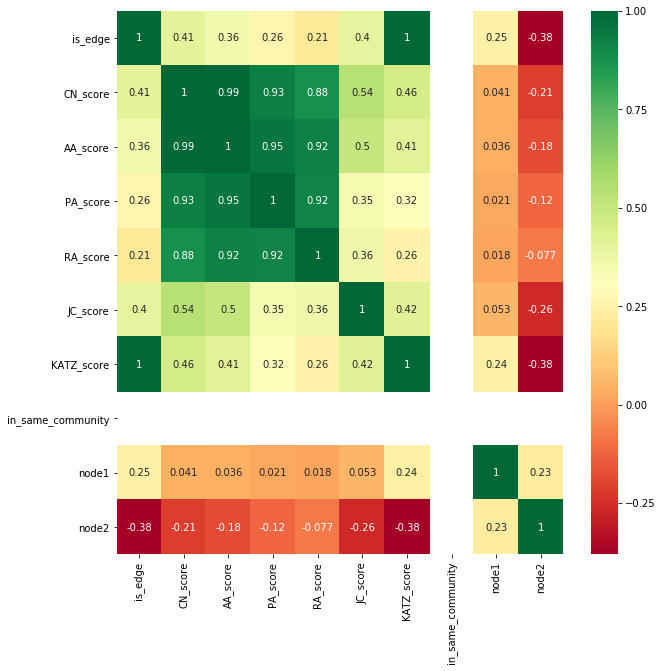

In [0]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")